In [1]:
!pip install -q efficientnet

In [2]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import glob
import math, re, os
import numpy as np
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

2021-09-26 20:23:25.245106: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-26 20:23:25.245234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470


2021-09-26 20:23:31.678525: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-26 20:23:31.681517: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-26 20:23:31.681557: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-26 20:23:31.681582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (39a518b93ad9): /proc/driver/nvidia/version does not exist
2021-09-26 20:23:31.684762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') + '/tfrecords-jpeg-512x512'
GCS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
BATCH_SIZE = 16*strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]

In [5]:
IMAGENET_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/imagenet/tfrecords-jpeg-512x512/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/inaturalist/tfrecords-jpeg-512x512/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/openimage/tfrecords-jpeg-512x512/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/oxford_102/tfrecords-jpeg-512x512/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_PATH_EXT + '/tf_flowers/tfrecords-jpeg-512x512/*.tfrec')
ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES


print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALIDATION_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

2021-09-26 20:23:38.644876: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-09-26 20:23:38.832252: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-09-26 20:23:39.026470: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-09-26 20:23:39.157141: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-09-26 20:23:39.292729: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Train TFRecord Files: 96
Validation TFRecord Files: 16
Test TFRecord Files: 16


In [6]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

In [7]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [8]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [10]:
def get_dataset(filenames, labeled=True, cache=False, repeat=False, ordered=False, shuffled=False):
    dataset = load_dataset(filenames, ordered=ordered ,labeled=labeled)
    if shuffled:
        dataset = dataset.shuffle(2048)
    if repeat:
        dataset = dataset.repeat()
    if cache: 
        dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [11]:
train_dataset = get_dataset(TRAINING_FILENAMES, repeat=True, shuffled=True)
valid_dataset = get_dataset(VALIDATION_FILENAMES, cache=True)
test_dataset = get_dataset(TEST_FILENAMES, labeled=False)

image_batch, label_batch = next(iter(train_dataset))

## Model

In [12]:
initial_learning_rate = 0.00001
maximal_learning_rate = 0.0005
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
    initial_learning_rate= initial_learning_rate,
    maximal_learning_rate= maximal_learning_rate,
    step_size= 8,
    scale_mode = 'iterations',
    gamma= 1.0,
    name = 'ExponentialCyclicalLearningRate',
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "flower_model.h5",
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=7, restore_best_weights=True
)

In [13]:
def make_model():
    enet = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='noisy-student',
        include_top=False
    )

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        #optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="sparse_categorical_crossentropy",
        metrics=['sparse_categorical_accuracy'],
    )
    return model

In [14]:
STEPS_PER_EPOCH = -(-12753 // BATCH_SIZE) #number of training images // batch_size
with strategy.scope():
    model = make_model()

history = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

model.load_weights("flower_model.h5")

258072576/258068648 [==============================] - 5s 0us/step
Epoch 1/100
100/100 [==============================] - 310s 1s/step - loss: 4.1508 - sparse_categorical_accuracy: 0.1561 - val_loss: 2.5188 - val_sparse_categorical_accuracy: 0.4965


2021-09-26 20:29:41.776269: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 89699, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632688181.772918383","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 89699, Output num: 0","grpc_status":3}


Epoch 2/100
100/100 [==============================] - 95s 947ms/step - loss: 2.0692 - sparse_categorical_accuracy: 0.5353 - val_loss: 2.2353 - val_sparse_categorical_accuracy: 0.4585
Epoch 3/100
100/100 [==============================] - 94s 941ms/step - loss: 0.7406 - sparse_categorical_accuracy: 0.8147 - val_loss: 2.3903 - val_sparse_categorical_accuracy: 0.4450
Epoch 4/100
100/100 [==============================] - 94s 940ms/step - loss: 1.0408 - sparse_categorical_accuracy: 0.7504 - val_loss: 1.6661 - val_sparse_categorical_accuracy: 0.6347
Epoch 5/100
100/100 [==============================] - 94s 939ms/step - loss: 1.3383 - sparse_categorical_accuracy: 0.7013 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.7047
Epoch 6/100
100/100 [==============================] - 95s 946ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.3822 - val_sparse_categorical_accuracy: 0.9116
Epoch 7/100
100/100 [==============================] - 94s 943ms/step - loss: 0.

### Prediction

In [15]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [16]:
dataset = get_dataset(VALIDATION_FILENAMES)
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

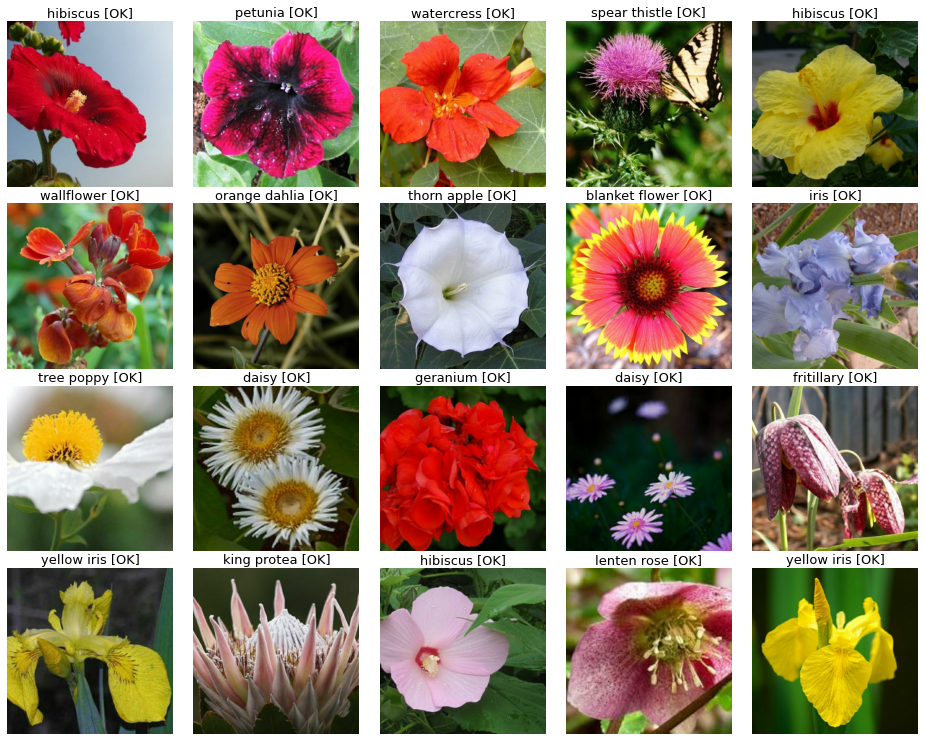

In [17]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [18]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

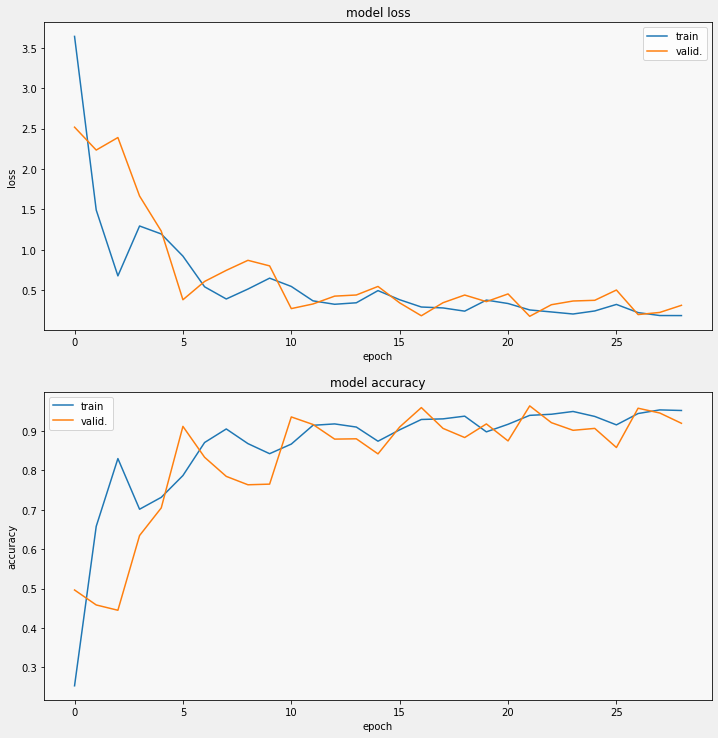

In [19]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [20]:
report_ds = get_dataset(VALIDATION_FILENAMES, ordered=True)
report_img = report_ds.map(lambda image, label: image)
report_labels = report_ds.map(lambda image, label: label).unbatch()

In [21]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

STEPS_PER_EPOCH = NUM_VALIDATION_IMAGES // BATCH_SIZE #number of training images // batch_size

y_true = next(iter(report_labels.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
y_pred = model.predict(report_img, steps=STEPS_PER_EPOCH)

matrix_preds = np.argmax(y_pred, axis=-1)

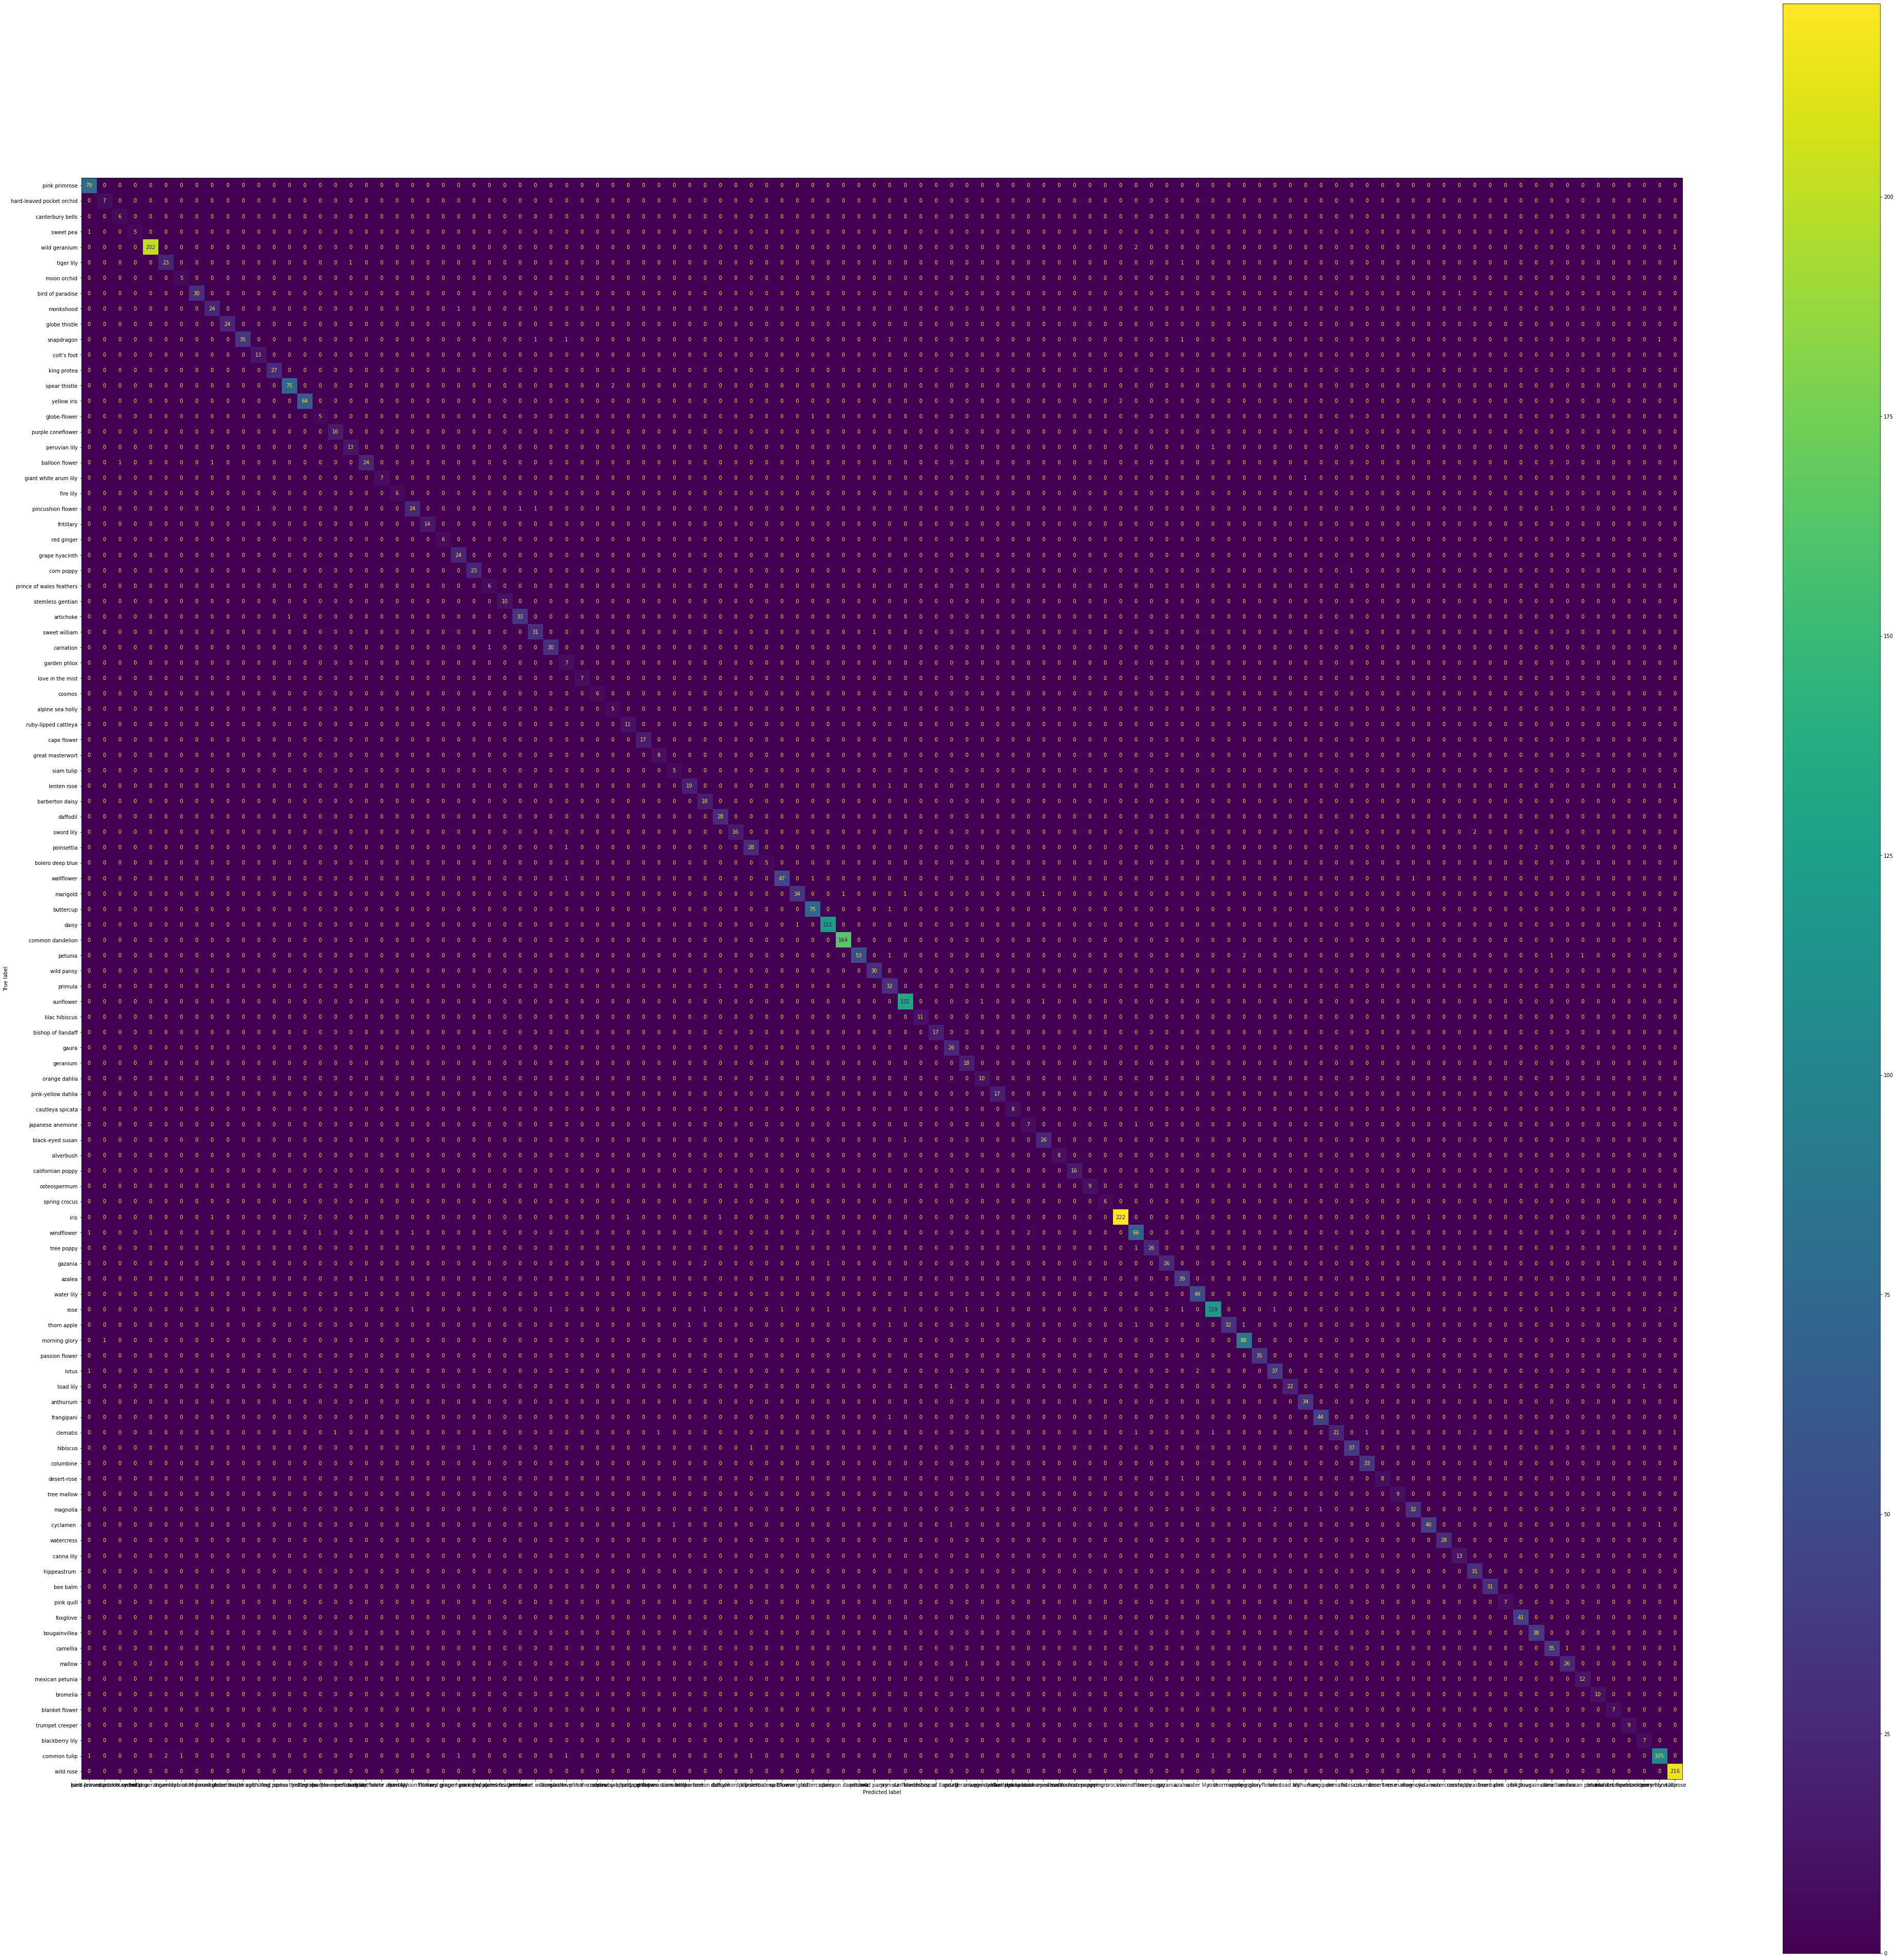

f1 score: 0.954, precision: 0.947, recall: 0.964


In [22]:
matrix = confusion_matrix(y_true, matrix_preds, labels=range(len(CLASSES)))
score = f1_score(y_true, matrix_preds, labels=range(len(CLASSES)), average='macro')
precision = precision_score(y_true, matrix_preds, labels=range(len(CLASSES)), average='macro')
recall = recall_score(y_true, matrix_preds, labels=range(len(CLASSES)), average='macro')

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(70,70))
disp.plot(ax=ax)
plt.show()

print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [23]:
test_ds = get_dataset(TEST_FILENAMES, labeled=False, ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities,axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Computing predictions...


2021-09-26 21:17:29.745813: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 286266, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632691049.745555977","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 286266, Output num: 0","grpc_status":3}


[ 67  28  83 ... 103 102  62]
Generating submission.csv file...
